

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

<big>**Ник на каггле Андрей Исупов. Скор 0.99256**</big>

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [51]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [7]:
import pickle
import numpy as np
from skimage import io

from PIL import Image
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

!nvidia-smi

In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [53]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [54]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [55]:
TRAIN_DIR = Path('./train/train/simpsons_dataset/')
TEST_DIR = Path('./test/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [56]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [57]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [58]:
len(np.unique(train_val_labels))
len(train_val_labels)

20933

Давайте посмотрим на наших героев внутри датасета.

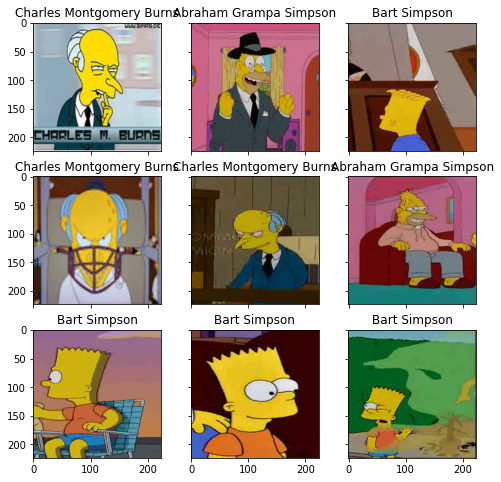

In [60]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [61]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [62]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [63]:
def train(train_files, val_files, model, opt, criterion, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
            
    return model, history

In [64]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [65]:
n_classes = len(np.unique(train_val_labels))

# Качаем модель
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [66]:
len(np.unique(train_val_labels))

42

In [67]:
for i, (name,param) in enumerate(model.named_parameters()):
    print(i, name)

0 conv1.weight
1 bn1.weight
2 bn1.bias
3 layer1.0.conv1.weight
4 layer1.0.bn1.weight
5 layer1.0.bn1.bias
6 layer1.0.conv2.weight
7 layer1.0.bn2.weight
8 layer1.0.bn2.bias
9 layer1.0.conv3.weight
10 layer1.0.bn3.weight
11 layer1.0.bn3.bias
12 layer1.0.downsample.0.weight
13 layer1.0.downsample.1.weight
14 layer1.0.downsample.1.bias
15 layer1.1.conv1.weight
16 layer1.1.bn1.weight
17 layer1.1.bn1.bias
18 layer1.1.conv2.weight
19 layer1.1.bn2.weight
20 layer1.1.bn2.bias
21 layer1.1.conv3.weight
22 layer1.1.bn3.weight
23 layer1.1.bn3.bias
24 layer1.2.conv1.weight
25 layer1.2.bn1.weight
26 layer1.2.bn1.bias
27 layer1.2.conv2.weight
28 layer1.2.bn2.weight
29 layer1.2.bn2.bias
30 layer1.2.conv3.weight
31 layer1.2.bn3.weight
32 layer1.2.bn3.bias
33 layer2.0.conv1.weight
34 layer2.0.bn1.weight
35 layer2.0.bn1.bias
36 layer2.0.conv2.weight
37 layer2.0.bn2.weight
38 layer2.0.bn2.bias
39 layer2.0.conv3.weight
40 layer2.0.bn3.weight
41 layer2.0.bn3.bias
42 layer2.0.downsample.0.weight
43 layer2.0.do

In [68]:
# Замораживаем градиенты
layers_to_unfreeze = 89
for param in list(model.parameters())[:-layers_to_unfreeze]:
    param.requires_grad = False

# Меняем классификатор
num_features = 2048
n_classes = len(np.unique(train_val_labels))
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, n_classes)
)

# Переводим на gpu
if train_on_gpu:
    model = model.cuda()
    
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Оптимизатор
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
optimizer = optim.AdamW(params_to_update, lr=1e-4)

# Динамический learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.conv3.weight
	 layer3.0.bn3.weight
	 layer3.0.bn3.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer3.1.bn2.bias
	 layer3.1.conv3.weight
	 layer3.1.bn3.weight
	 layer3.1.bn3.bias
	 layer3.2.conv1.weight
	 layer3.2.bn1.weight
	 layer3.2.bn1.bias
	 layer3.2.conv2.weight
	 layer3.2.bn2.weight
	 layer3.2.bn2.bias
	 layer3.2.conv3.weight
	 layer3.2.bn3.weight
	 layer3.2.bn3.bias
	 layer3.3.conv1.weight
	 layer3.3.bn1.weight
	 layer3.3.bn1.bias
	 layer3.3.conv2.weight
	 layer3.3.bn2.weight
	 layer3.3.bn2.bias
	 layer3.3.conv3.weight
	 layer3.3.bn3.weight
	 layer3.3.bn3.bias
	 layer3.4.conv1.weight
	 layer3.4.bn1.weight
	 layer3.4.bn1.bias
	 layer3.4.conv2.weight
	 layer3.4.bn2.weight
	 lay

Запустим обучение сети.

In [69]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [70]:
model, history = train(train_dataset, val_dataset, model, optimizer, loss_fn, epochs=25, batch_size=64)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 0.8504349717800234


epoch:   4%|▍         | 1/25 [03:52<1:32:53, 232.25s/it]


Epoch 001 train_loss: 0.8504     val_loss 0.1921 train_acc 0.8482 val_acc 0.9530
loss 0.21007397585969717


epoch:   8%|▊         | 2/25 [07:38<1:28:20, 230.47s/it]


Epoch 002 train_loss: 0.2101     val_loss 0.2416 train_acc 0.9459 val_acc 0.9412
loss 0.08366544071436156


epoch:  12%|█▏        | 3/25 [11:23<1:23:55, 228.91s/it]


Epoch 003 train_loss: 0.0837     val_loss 0.2094 train_acc 0.9764 val_acc 0.9473
loss 0.09702645940999786


epoch:  16%|█▌        | 4/25 [15:08<1:19:42, 227.72s/it]


Epoch 004 train_loss: 0.0970     val_loss 0.3582 train_acc 0.9744 val_acc 0.9142
loss 0.05576992434528335


epoch:  20%|██        | 5/25 [18:54<1:15:39, 227.00s/it]


Epoch 005 train_loss: 0.0558     val_loss 0.1282 train_acc 0.9850 val_acc 0.9692
loss 0.03510076334686848


epoch:  24%|██▍       | 6/25 [22:39<1:11:44, 226.54s/it]


Epoch 006 train_loss: 0.0351     val_loss 0.1379 train_acc 0.9909 val_acc 0.9671
loss 0.04296876090907744


epoch:  28%|██▊       | 7/25 [26:27<1:08:07, 227.09s/it]


Epoch 007 train_loss: 0.0430     val_loss 0.1781 train_acc 0.9883 val_acc 0.9576
loss 0.03343724020743671


epoch:  32%|███▏      | 8/25 [30:13<1:04:14, 226.76s/it]


Epoch 008 train_loss: 0.0334     val_loss 0.2789 train_acc 0.9909 val_acc 0.9496
loss 0.04768910162275202


epoch:  36%|███▌      | 9/25 [33:59<1:00:24, 226.50s/it]


Epoch 009 train_loss: 0.0477     val_loss 0.1934 train_acc 0.9875 val_acc 0.9580
loss 0.033221661618825775


epoch:  40%|████      | 10/25 [37:45<56:35, 226.34s/it]


Epoch 010 train_loss: 0.0332     val_loss 0.1868 train_acc 0.9906 val_acc 0.9626
loss 0.008370092170306027


epoch:  44%|████▍     | 11/25 [41:32<52:48, 226.35s/it]


Epoch 011 train_loss: 0.0084     val_loss 0.1444 train_acc 0.9980 val_acc 0.9702
loss 0.0029015874346220633


epoch:  48%|████▊     | 12/25 [45:18<49:02, 226.32s/it]


Epoch 012 train_loss: 0.0029     val_loss 0.1159 train_acc 0.9992 val_acc 0.9784
loss 0.0008080688591627815


epoch:  52%|█████▏    | 13/25 [49:04<45:15, 226.29s/it]


Epoch 013 train_loss: 0.0008     val_loss 0.1173 train_acc 0.9998 val_acc 0.9794
loss 0.000381013882905243


epoch:  56%|█████▌    | 14/25 [52:50<41:28, 226.25s/it]


Epoch 014 train_loss: 0.0004     val_loss 0.1126 train_acc 0.9997 val_acc 0.9817
loss 0.0005028577899712724


epoch:  60%|██████    | 15/25 [56:36<37:41, 226.16s/it]


Epoch 015 train_loss: 0.0005     val_loss 0.1118 train_acc 0.9998 val_acc 0.9828
loss 0.000495600396670555


epoch:  64%|██████▍   | 16/25 [1:00:22<33:54, 226.09s/it]


Epoch 016 train_loss: 0.0005     val_loss 0.1129 train_acc 0.9997 val_acc 0.9824
loss 0.0005001680928331824


epoch:  68%|██████▊   | 17/25 [1:04:08<30:08, 226.08s/it]


Epoch 017 train_loss: 0.0005     val_loss 0.1145 train_acc 0.9997 val_acc 0.9832
loss 0.0003544821936704366


epoch:  72%|███████▏  | 18/25 [1:07:55<26:23, 226.18s/it]


Epoch 018 train_loss: 0.0004     val_loss 0.1152 train_acc 0.9997 val_acc 0.9830
loss 0.000257869327155011


epoch:  76%|███████▌  | 19/25 [1:11:41<22:37, 226.18s/it]


Epoch 019 train_loss: 0.0003     val_loss 0.1170 train_acc 0.9999 val_acc 0.9826
loss 0.0005095666866673428


epoch:  80%|████████  | 20/25 [1:15:27<18:50, 226.08s/it]


Epoch 020 train_loss: 0.0005     val_loss 0.1140 train_acc 0.9997 val_acc 0.9836
loss 0.0003670501348666292


epoch:  84%|████████▍ | 21/25 [1:19:13<15:04, 226.04s/it]


Epoch 021 train_loss: 0.0004     val_loss 0.1184 train_acc 0.9998 val_acc 0.9826
loss 0.0003666166665337523


epoch:  88%|████████▊ | 22/25 [1:22:59<11:18, 226.06s/it]


Epoch 022 train_loss: 0.0004     val_loss 0.1184 train_acc 0.9999 val_acc 0.9830
loss 0.0003777993095040138


epoch:  92%|█████████▏| 23/25 [1:26:44<07:31, 225.97s/it]


Epoch 023 train_loss: 0.0004     val_loss 0.1156 train_acc 0.9999 val_acc 0.9830
loss 0.00034684440204302817


epoch:  96%|█████████▌| 24/25 [1:30:30<03:45, 225.93s/it]


Epoch 024 train_loss: 0.0003     val_loss 0.1269 train_acc 0.9999 val_acc 0.9815
loss 0.0006396217309990092


epoch: 100%|██████████| 25/25 [1:34:16<00:00, 226.26s/it]


Epoch 025 train_loss: 0.0006     val_loss 0.1310 train_acc 0.9999 val_acc 0.9805


Построим кривые обучения

In [71]:
loss, acc, val_loss, val_acc = zip(*history)

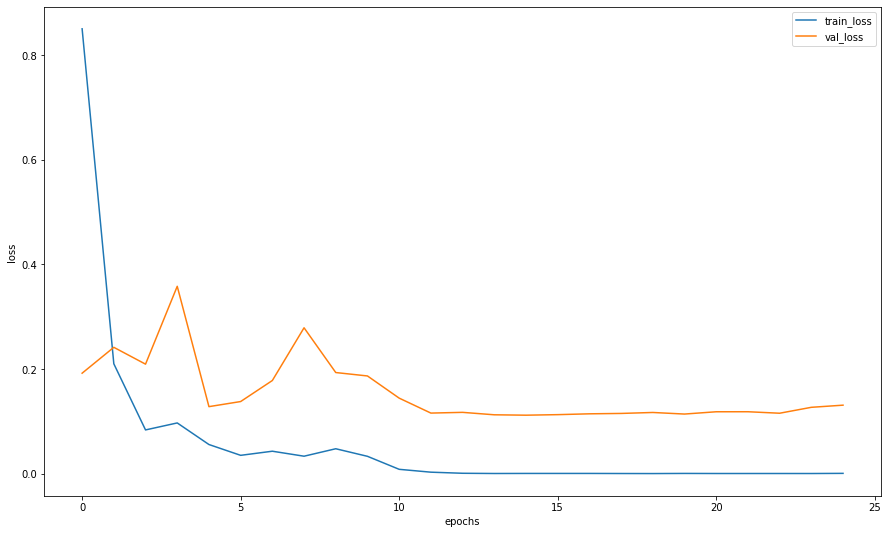

In [72]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [73]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [74]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [75]:
idxs = list(map(int, np.random.uniform(0,250, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [76]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [77]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [78]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)

array([0.96969697, 1.        , 0.        ])

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

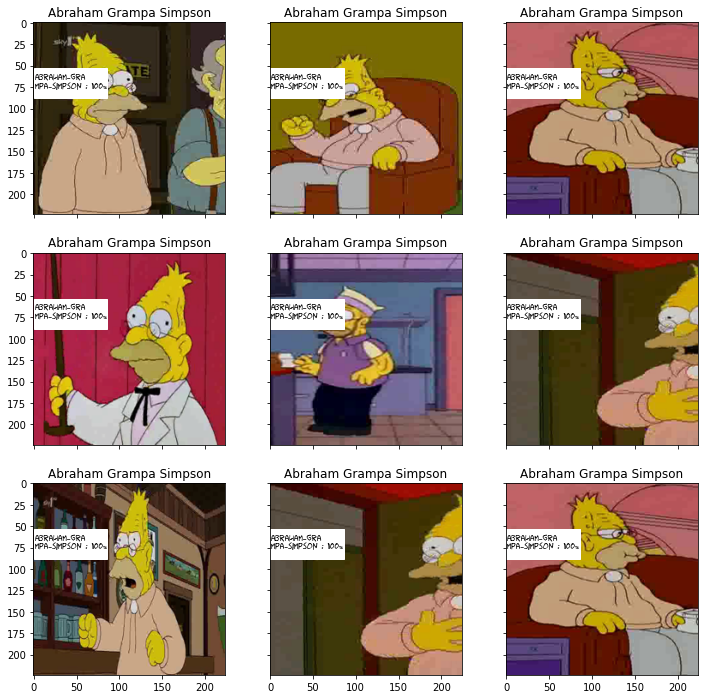

In [79]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [80]:
len(test_files)

991

In [81]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [82]:
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [83]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit['ind'] = my_submit['Id'].apply(lambda x: x[3:-4])
my_submit['ind'] = my_submit['ind'].astype('int')
my_submit.sort_values(by='ind', inplace=True)
my_submit.reset_index(inplace=True, drop=True)
my_submit.drop(columns=['ind'], inplace=True, axis=1)

my_submit.head(25)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson
5,img5.jpg,principal_skinner
6,img6.jpg,krusty_the_clown
7,img7.jpg,apu_nahasapeemapetilon
8,img8.jpg,principal_skinner
9,img9.jpg,comic_book_guy


In [84]:
my_submit.to_csv('./ResNet2_submission.csv', index=False)

In [85]:
torch.save(model.state_dict(), 'gdrive/My Drive/ResNet2.pth')

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
